# Week 7

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import graphviz
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Exercise 1

#### 1.	Use the German credit rating dataset “German Credit Data.csv” , Decision tree classifier to predict good or bad credit. Use “sklearn.model_selection”  and  GridSearchCV to search the hyperparameter values and report the most optimal one. Configure the grid search to search for optimal parameters:
   - Splitting criteria: gini or entropy.
   - Maximum depth of decision tree ranging from 2 to 10.
   - The searching of optimal parameter will be validated using 10-fold cross validation and the most optimal parameter will be chosen based on ROC AUC score.
   
#### 2. Visualize the tree using graphviz toolkit.
#### 3. Display the text representation of the rules learnt.

In [3]:
df = pd.read_csv("German Credit Data.csv")
df.head()

,checkin_acc,duration,credit_history,amount,savings_acc,present_emp_since,inst_rate,personal_status,residing_since,age,inst_plans,num_credits,job,status
0,A11,6,A34,1169,A65,A75,4,A93,4,67,A143,2,A173,0
1,A12,48,A32,5951,A61,A73,2,A92,2,22,A143,1,A173,1
2,A14,12,A34,2096,A61,A74,2,A93,3,49,A143,1,A172,0
3,A11,42,A32,7882,A61,A74,2,A93,4,45,A143,1,A173,0
4,A11,24,A33,4870,A61,A73,3,A93,4,53,A143,2,A173,1


In [4]:
df_encoded = df.copy()
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
X = df_encoded.drop(columns=["status"])
y = df_encoded["status"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(2, 11)
}

In [8]:
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='roc_auc')

In [9]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters for German Credit Data:", best_params)
print("Best ROC AUC Score (CV):", best_score)

Best Parameters for German Credit Data: {'criterion': 'entropy', 'max_depth': 3}
Best ROC AUC Score (CV): 0.7207217261904761


In [10]:
best_dt = grid_search.best_estimator_
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [11]:
dot_data = export_graphviz(
    best_dt, 
    out_file=None,
    feature_names=X.columns,
    class_names=['Bad Credit', 'Good Credit'],
    filled=True, rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)

In [12]:
# graph.render("GermanCreditDecisionTree")
# print("Decision tree visualization saved as 'GermanCreditDecisionTree.pdf'.")

In [13]:
dot_data = export_graphviz(
    best_dt, 
    out_file=None,
    feature_names=X.columns,
    class_names=['Bad Credit', 'Good Credit'],
    filled=True, rounded=True,
    special_characters=True
)
print(dot_data)


digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<checkin_acc &le; 1.5<br/>entropy = 0.881<br/>samples = 800<br/>value = [560, 240]<br/>class = Bad Credit>, fillcolor="#f0b78e"] ;
1 [label=<duration &le; 22.5<br/>entropy = 0.988<br/>samples = 433<br/>value = [244, 189]<br/>class = Bad Credit>, fillcolor="#f9e3d2"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<credit_history &le; 1.5<br/>entropy = 0.928<br/>samples = 242<br/>value = [159, 83]<br/>class = Bad Credit>, fillcolor="#f3c3a0"] ;
1 -> 2 ;
3 [label=<entropy = 0.863<br/>samples = 21<br/>value = [6, 15]<br/>class = Good Credit>, fillcolor="#88c4ef"] ;
2 -> 3 ;
4 [label=<entropy = 0.89<br/>samples = 221<br/>value = [153, 68]<br/>class = Bad Credit>, fillcolor="#f1b991"] ;
2 -> 4 ;
5 [label=<savings_acc &le; 2.5<br/>entropy = 0.991<br/>samples = 191<br/>value = [85, 106]<br/>class = Good Credit>, fillcolor="#d8ecfa"] ;


<img src="Week7_Ex1_2nd.png" width="1000" height="600">

In [14]:
tree_rules = export_text(best_dt, feature_names=list(X.columns))
print("\nText Representation of Decision Rules:\n")
print(tree_rules)


Text Representation of Decision Rules:

|--- checkin_acc <= 1.50
|   |--- duration <= 22.50
|   |   |--- credit_history <= 1.50
|   |   |   |--- class: 1
|   |   |--- credit_history >  1.50
|   |   |   |--- class: 0
|   |--- duration >  22.50
|   |   |--- savings_acc <= 2.50
|   |   |   |--- class: 1
|   |   |--- savings_acc >  2.50
|   |   |   |--- class: 0
|--- checkin_acc >  1.50
|   |--- inst_plans <= 0.50
|   |   |--- amount <= 3741.00
|   |   |   |--- class: 0
|   |   |--- amount >  3741.00
|   |   |   |--- class: 1
|   |--- inst_plans >  0.50
|   |   |--- present_emp_since <= 2.50
|   |   |   |--- class: 0
|   |   |--- present_emp_since >  2.50
|   |   |   |--- class: 0



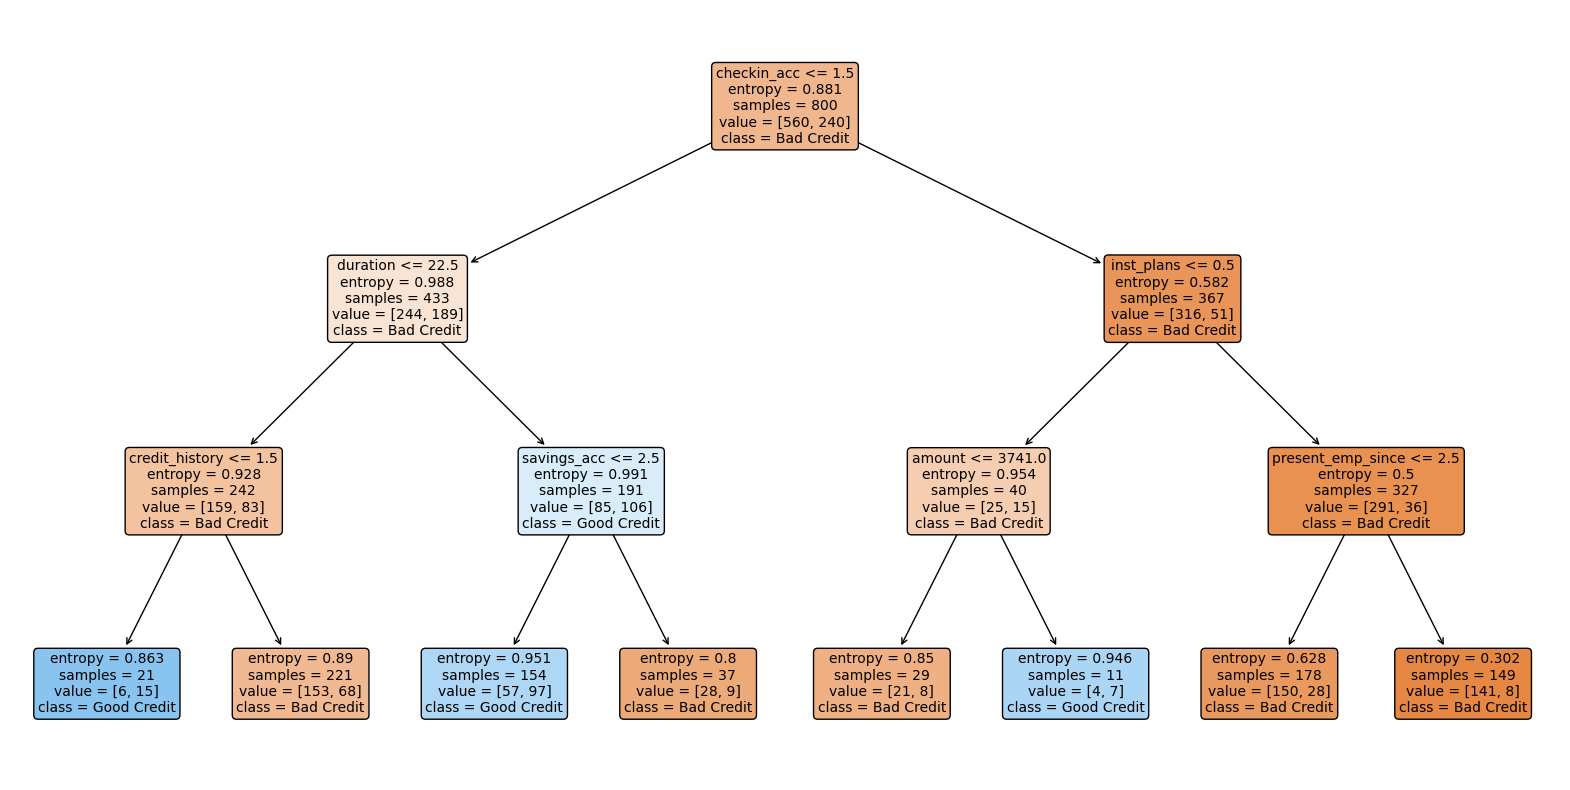

In [15]:
# Using matplotlib
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    feature_names=X.columns,
    class_names=['Bad Credit', 'Good Credit'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

## Exercise 2

####  Use the iris dataset to implement , Decision tree classifier
#### Implement a decision tree classifier, Train it on 80% of the dataset and test on the remaining 20%.
#### Print the classification report and confusion matrix.
#### Optimize Hyperparameters Using Grid Search
   - Use GridSearchCV to tune max_depth, min_samples_split, and criterion.
   - Report the best hyperparameter combination and corresponding accuracy.
#### Pruning the Decision Tree
   - •	Implement post-pruning using cost-complexity pruning (ccp_alpha).
   - •	Find the optimal ccp_alpha by plotting accuracy vs. ccp_alpha values.
#### Feature Importance Analysis
   - Extract and plot feature importance values from the trained decision tree.
   - Drop the least important feature and retrain the model. Does accuracy improve or decline?


In [16]:
iris = pd.read_csv("Iris.csv")

In [17]:
if 'Id' in iris.columns:
    iris.drop(columns=['Id'], inplace=True)

In [18]:
X_iris = iris.drop(columns=["Species"])
y_iris = iris["Species"]

In [19]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris)

In [20]:
dt_iris = DecisionTreeClassifier(random_state=42)
dt_iris.fit(X_train_i, y_train_i)
y_pred_i = dt_iris.predict(X_test_i)
print("Classification Report (without tuning):")
print(classification_report(y_test_i, y_pred_i))
print("Confusion Matrix (without tuning):")
print(confusion_matrix(y_test_i, y_pred_i))

Classification Report (without tuning):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30

Confusion Matrix (without tuning):
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


In [21]:
param_grid_iris = {
    "max_depth": np.arange(2, 11),
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}
grid_search_iris = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_iris, 
    cv=10, 
    scoring="accuracy", 
    n_jobs=-1
)
grid_search_iris.fit(X_train_i, y_train_i)
best_params_iris = grid_search_iris.best_params_
best_score_iris = grid_search_iris.best_score_
print("\nBest Parameters for Iris Dataset:", best_params_iris)
print("Best CV Accuracy for Iris Dataset:", best_score_iris)


Best Parameters for Iris Dataset: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
Best CV Accuracy for Iris Dataset: 0.9583333333333333


In [22]:
best_dt_iris = grid_search_iris.best_estimator_
y_pred_i_tuned = best_dt_iris.predict(X_test_i)
accuracy_tuned = accuracy_score(y_test_i, y_pred_i_tuned)
print("Test Accuracy of Tuned Model:", accuracy_tuned)
print("Classification Report (Tuned Model):")
print(classification_report(y_test_i, y_pred_i_tuned))
print("Confusion Matrix (Tuned Model):")
print(confusion_matrix(y_test_i, y_pred_i_tuned))

Test Accuracy of Tuned Model: 0.9333333333333333
Classification Report (Tuned Model):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30

Confusion Matrix (Tuned Model):
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


In [23]:
path = best_dt_iris.cost_complexity_pruning_path(X_train_i, y_train_i)
ccp_alphas = path.ccp_alphas

train_scores = []
test_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_i, y_train_i)
    train_scores.append(clf.score(X_train_i, y_train_i))
    test_scores.append(clf.score(X_test_i, y_test_i))


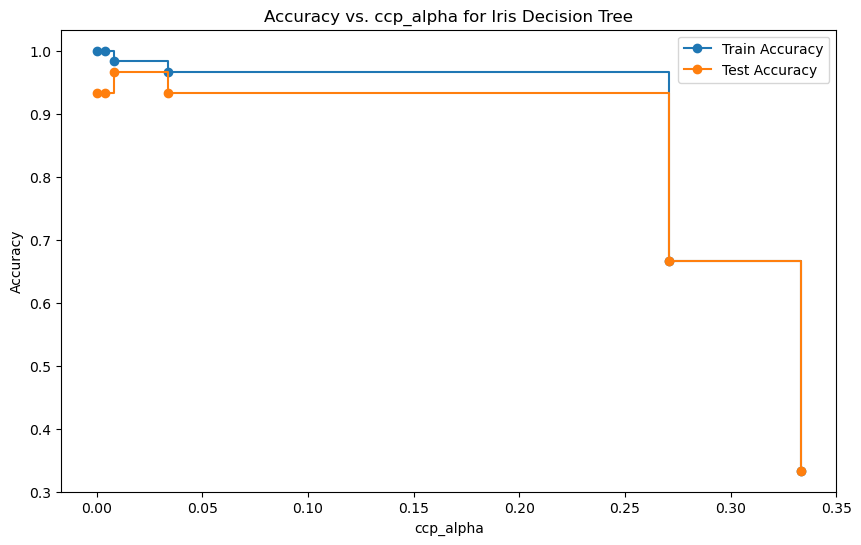

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker="o", label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker="o", label="Test Accuracy", drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. ccp_alpha for Iris Decision Tree")
plt.legend()
plt.show()

In [25]:
optimal_alpha = ccp_alphas[np.argmax(test_scores)]
print("Optimal ccp_alpha:", optimal_alpha)

Optimal ccp_alpha: 0.00811403508771929


In [26]:
importances = best_dt_iris.feature_importances_
feature_names = X_train_i.columns
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: SepalLengthCm, Importance: 0.0063
Feature: SepalWidthCm, Importance: 0.0169
Feature: PetalLengthCm, Importance: 0.5656
Feature: PetalWidthCm, Importance: 0.4112


In [27]:
least_important_feature = feature_names[np.argmin(importances)]
print("Least important feature:", least_important_feature)


Least important feature: SepalLengthCm


In [28]:
X_train_i_reduced = X_train_i.drop(columns=[least_important_feature])
X_test_i_reduced = X_test_i.drop(columns=[least_important_feature])

In [29]:
best_dt_iris_retrained = DecisionTreeClassifier(random_state=42, **best_params_iris)
best_dt_iris_retrained.fit(X_train_i_reduced, y_train_i)
accuracy_retrained = best_dt_iris_retrained.score(X_test_i_reduced, y_test_i)
print("Test Accuracy after dropping the least important feature:", accuracy_retrained)

if accuracy_retrained > accuracy_tuned:
    print("Accuracy improved after dropping the feature.")
else:
    print("Accuracy declined after dropping the feature.")

Test Accuracy after dropping the least important feature: 0.9666666666666667
Accuracy improved after dropping the feature.
